# Credit Risk Prediction - Classification Problem

## Preamble

This project focuses on comparing machine learning models for credit risk assessment, particularly focusing on 'loan_status' classification. Our objective is to evaluate these models within a business context, addressing two primary scenarios:
1. Avoiding denial of credit to a customer capable of loan repayment.
2. Mitigating the risk of granting credit to a consumer likely to default.

We follow structured approach:
1. Conducting standard exploratory data analysis (EDA) for initial insights and understanding of raw data.
2. Employing enhanced EDA with ydata-profiling, a sophisticated data profiling tool.
3. Performing data cleaning and addressing outliers.
4. Addressing imbalanced classes using sklearn resampling and SMOTE techniques.
5. Training various ML models including logistic regression, decision trees, etc.
6. Evaluating model performance based on accuracy, precision, recall, and specificity.

Dataset was obtain through kaggle.com.
https://www.kaggle.com/datasets/laotse/credit-risk-dataset

**Feature Name** Description
* **person_age** Age
* **person_income** Annual income
* **person_home_ownership** Type of home ownership [Rent, Mortgage, Own, Other]
* **person_emp_length** Employment length (in years)
* **loan_intent** Intent behind loan
* **loan_grade** Loan grade based on credit [A-G]
* **loan_amnt** Loan amount
* **loan_int_rate** Interest rate for the loan
* **loan_status** Loan status [0 is non default 1 is default]
* **loan_percent_income** Percentage of income represented by the loan amount
* **cb_person_default_on_file** Historical default [Y, N]
* **cb_preson_cred_hist_length** Credit history length

## Table of contents

* [Import Libraries](#0)
* [Exploratory Data Analysis (EDA)](#1)
    * [Load Data](#1.1)
    * [Data Overview and Descriptive Statistics](#1.2)
    * [Feature Assessment and Visualization](#1.3)
        * [Univariate Analysis](#1.3.1)
        * [Multivariate Analysis](#1.3.2)
    * [Data Quality Evaluation](#1.4)
    * [Feature Engineering](#1.5)
* [EDA using ydata-profiling](#2)  
    * [Load Data](#2.1)
    * [Profile Report](#2.2)
* [Data preprocessing](#3)
* [Machine Learning](#4)
* [Conclusions](#5)

## <a name='0'></a>Import Libraries

In [663]:
# basic
import pandas as pd
pd.options.display.max_colwidth=150   ## this is used to set the column width.

## Note: Other available must know options are:
# pd.options.display.max_rows=x  ## controls the max rows to be displayed on screen
# pd.options.display.max_columns=x  ## controls the max columns to be displayed on screen
# pd.options.display.precision=x  ## controls the precision of each floating points to be displayed on screen
# pd.options.display.float_format = '{:.2f}%'.format  ## controls the format of displaying numbers on screen. 

import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")

import os

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

# styling
%matplotlib inline
sns.set_style('darkgrid')
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.facecolor'] = '#00000000'

In [664]:
# setting the seed to allow reproducibility
np.random.seed(31415)

## <a name='1'></a>Exploratory Data Analysis (EDA)

Standard approach

### <a name='1.1'></a>Load Data

In [665]:
# load dataset for exploration and keep raw data for reference 
raw_data = pd.read_csv('credit_risk_dataset.csv')
data = pd.read_csv('credit_risk_dataset.csv')

data.sample(5).reset_index(drop=True)  # overview

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,24,50000,RENT,6.0,PERSONAL,A,4000,7.66,0,0.08,N,4
1,26,102000,MORTGAGE,6.0,DEBTCONSOLIDATION,C,6000,13.61,0,0.06,N,2
2,25,36000,MORTGAGE,0.0,DEBTCONSOLIDATION,A,9000,7.14,0,0.25,N,4
3,29,47000,RENT,0.0,MEDICAL,B,3000,10.25,0,0.06,N,7
4,36,42000,MORTGAGE,2.0,VENTURE,B,6000,10.59,0,0.14,N,13


### <a name='1.2'></a>Dataset Overview and Descriptive Statistics

In [666]:
# check basic info about the dataset
data.info()
#data.dtypes -- alternatively for only data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [667]:
# check for unique values
data.nunique()

person_age                      58
person_income                 4295
person_home_ownership            4
person_emp_length               36
loan_intent                      6
loan_grade                       7
loan_amnt                      753
loan_int_rate                  348
loan_status                      2
loan_percent_income             77
cb_person_default_on_file        2
cb_person_cred_hist_length      29
dtype: int64

In [668]:
# make list of numerival and categorical columns
num_col = []
cat_col = []
for i, j in data.dtypes.items():
    if j == 'object':
        cat_col.append(i)
    else:
        num_col.append(i)     
    
print("The number of Categorical columns are:",len(cat_col))
print("The number of Numerical columns are:",len(num_col))

The number of Categorical columns are: 4
The number of Numerical columns are: 8


In [669]:
# print columns with the number of unique values they have
print("The NUMERICAL columns are:\n")
for i in num_col:
    print("->",i,"-",data[i].nunique())
    
print("\n---------------------------\n")
print("The CATEGORICAL columns are:\n")
for i in cat_col:
    print("->",i,"-",data[i].nunique())

The NUMERICAL columns are:

-> person_age - 58
-> person_income - 4295
-> person_emp_length - 36
-> loan_amnt - 753
-> loan_int_rate - 348
-> loan_status - 2
-> loan_percent_income - 77
-> cb_person_cred_hist_length - 29

---------------------------

The CATEGORICAL columns are:

-> person_home_ownership - 4
-> loan_intent - 6
-> loan_grade - 7
-> cb_person_default_on_file - 2


In [670]:
# describe numeric feautures
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [671]:
# describe categorical feautures
data.describe(include='object')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,32581,32581,32581,32581
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,16446,6453,10777,26836


In [672]:
# overview of caegorical features
for col in cat_col:
    categories = data.groupby(col).size()
    print(categories, '\n --------------------------------- \n')

person_home_ownership
MORTGAGE    13444
OTHER         107
OWN          2584
RENT        16446
dtype: int64 
 --------------------------------- 

loan_intent
DEBTCONSOLIDATION    5212
EDUCATION            6453
HOMEIMPROVEMENT      3605
MEDICAL              6071
PERSONAL             5521
VENTURE              5719
dtype: int64 
 --------------------------------- 

loan_grade
A    10777
B    10451
C     6458
D     3626
E      964
F      241
G       64
dtype: int64 
 --------------------------------- 

cb_person_default_on_file
N    26836
Y     5745
dtype: int64 
 --------------------------------- 



In [673]:
# duplicates
dupl = data.duplicated().sum()
print(f'There are {dupl} duplicated rows.')

There are 165 duplicated rows.


It is not strange to find 'repeated' observations in our dataset as several people might share the same set of features. Thus, we will not remove duplicates from our dataframe. 

In [674]:
# NULL values
data.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

We will deal with NaN values later on be remowing rows containing NULLs.

### <a name='1.3'></a>Feature Assessment and Visualization

#### <a name='1.3.1'></a>Univariate Analysis

In [675]:
# a decisive feature is 'loan_status' - let's find out 0 - 1 proportion
data.loan_status.value_counts()

loan_status
0    25473
1     7108
Name: count, dtype: int64

In [676]:
print('Proportion: \n')
for index, value in data.loan_status.value_counts().items():
    print(f'{index} \t {(value/data.shape[0])}')

Proportion: 

0 	 0.7818360394094718
1 	 0.21816396059052823


Text(0.5, 1.0, 'Loan Status')

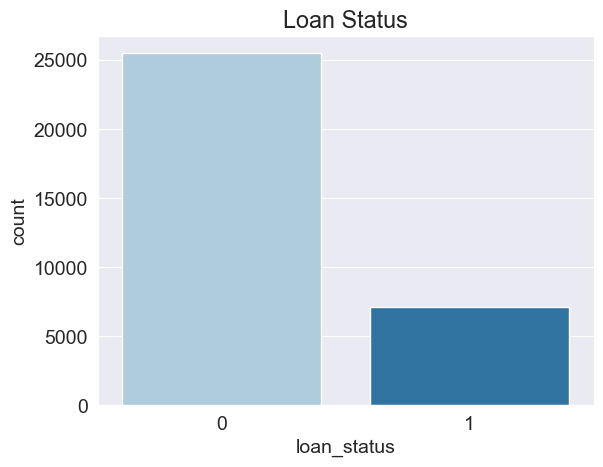

In [677]:
# visualization
sns.countplot(x=data['loan_status'], palette='Paired')
plt.title('Loan Status')

loan_status: Loan status, where 0 indicates non-default and 1 indicates default.
* 0: Non-default - The borrower successfully repaid the loan as agreed, and there was no default.
* 1: Default - The borrower failed to repay the loan according to the agreed-upon terms and defaulted on the loan.

One of the target class labels’ numbers of observation is significantly lower than the other.

The class '0' is the **majority class**. The class '1' is the **minority class**.

The data is highly **IMBALANCED.**

In [678]:
# function: count number of people between x and y of a given atribute
def atr_group(df, col_name, arr):  # dataframe, column name, array with group borders
    print(f'Max {col_name}: {df[col_name].max()}')
    print(f'Min {col_name}: {df[col_name].min()}')
    print("\n---------------------------\n")
    lenarr = len(arr)
    for i in range(0, lenarr-1):
        next = arr[i]+1
        num_people = df[col_name].between(next,arr[i+1]).sum()
        print(f'{col_name} between {next} and {arr[i+1]} \t --- \t Number of people: {num_people}')

In [679]:
# check for person age
atr_group(data, 'person_age', [0, 18, 26, 36, 46, 56, 66, 76, 86, 100, 140])

Max person_age: 144
Min person_age: 20

---------------------------

person_age between 1 and 18 	 --- 	 Number of people: 0
person_age between 19 and 26 	 --- 	 Number of people: 17829
person_age between 27 and 36 	 --- 	 Number of people: 11834
person_age between 37 and 46 	 --- 	 Number of people: 2360
person_age between 47 and 56 	 --- 	 Number of people: 434
person_age between 57 and 66 	 --- 	 Number of people: 98
person_age between 67 and 76 	 --- 	 Number of people: 17
person_age between 77 and 86 	 --- 	 Number of people: 3
person_age between 87 and 100 	 --- 	 Number of people: 1
person_age between 101 and 140 	 --- 	 Number of people: 2


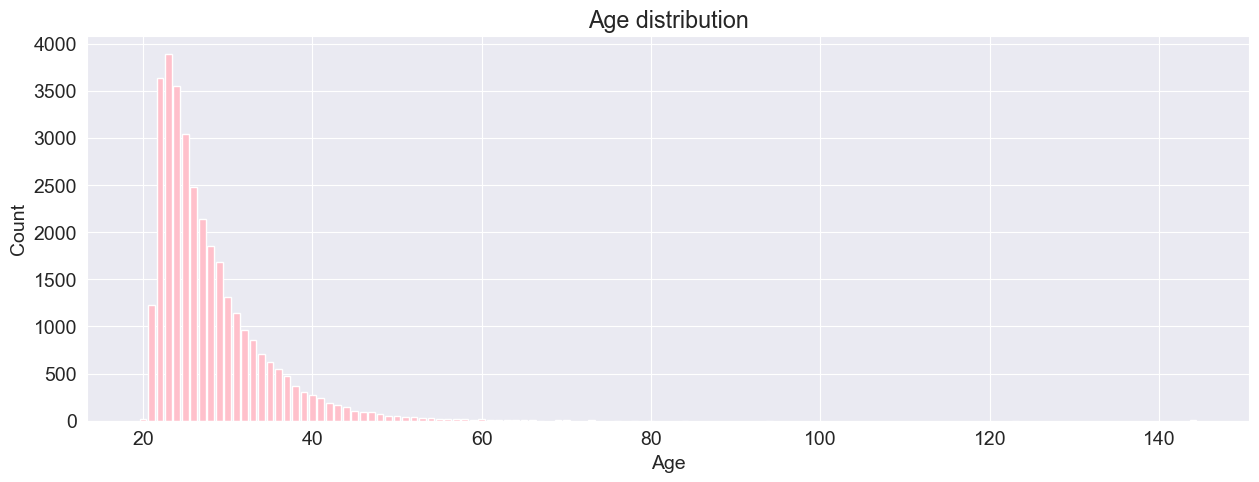

In [680]:
# age distribution
counts = data['person_age'].value_counts().values
age = data['person_age'].value_counts().index

fig = plt.figure(figsize = (15, 5))
plt.bar(age, counts, color='pink')
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Using common sense, max person age = 140 is quite unrealistic. Later on, we will remove records with person age > 70.

In [681]:
# check for person income
atr_group(data, 'person_income', [0, 25000, 50000, 75000, 100000, 200000, 500000, 1000000, 6000000])

Max person_income: 6000000
Min person_income: 4000

---------------------------

person_income between 1 and 25000 	 --- 	 Number of people: 2469
person_income between 25001 and 50000 	 --- 	 Number of people: 11613
person_income between 50001 and 75000 	 --- 	 Number of people: 9622
person_income between 75001 and 100000 	 --- 	 Number of people: 4670
person_income between 100001 and 200000 	 --- 	 Number of people: 3760
person_income between 200001 and 500000 	 --- 	 Number of people: 394
person_income between 500001 and 1000000 	 --- 	 Number of people: 44
person_income between 1000001 and 6000000 	 --- 	 Number of people: 9


Person annual income > 1000000 is considered an outlier and shall be removed later on.

In [682]:
# check for loan amount
atr_group(data, 'loan_amnt', [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000])

Max loan_amnt: 35000
Min loan_amnt: 500

---------------------------

loan_amnt between 1 and 5000 	 --- 	 Number of people: 9489
loan_amnt between 5001 and 10000 	 --- 	 Number of people: 12040
loan_amnt between 10001 and 15000 	 --- 	 Number of people: 6123
loan_amnt between 15001 and 20000 	 --- 	 Number of people: 2789
loan_amnt between 20001 and 25000 	 --- 	 Number of people: 1689
loan_amnt between 25001 and 30000 	 --- 	 Number of people: 231
loan_amnt between 30001 and 35000 	 --- 	 Number of people: 220


In [683]:
# function to display a swatch plot of all available color sequences
#px.colors.sequential.swatches() 

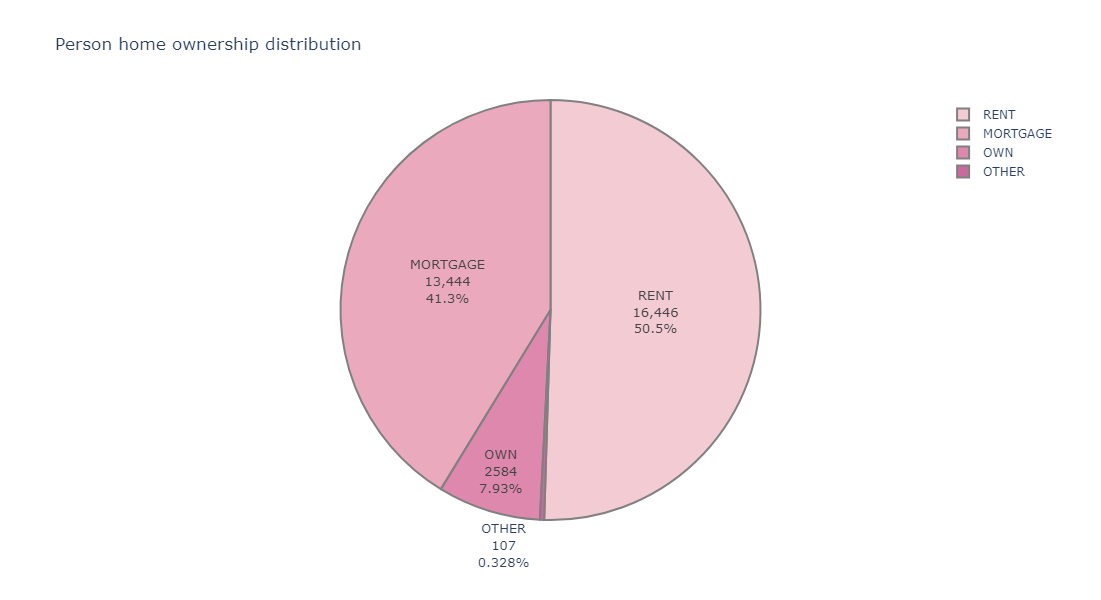

In [684]:
counts = data.person_home_ownership.value_counts()

fig = px.pie(values=counts.values, names=counts.index, color_discrete_sequence=px.colors.sequential.Magenta, 
             title='Person home ownership distribution')

fig.update_traces(textinfo='label+percent+value', textfont_size=13, marker=dict(line=dict(color='#102000', width=.2)))

fig.data[0].marker.line.width = 2
fig.data[0].marker.line.color = 'gray'
fig.update_layout(width=800, height=600)
fig.show()

Most people who take on a loan do not have their own house.

In [685]:
# check for loan amount
atr_group(data, 'person_emp_length', [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 55, 60, 100, 130])

Max person_emp_length: 123.0
Min person_emp_length: 0.0

---------------------------

person_emp_length between 1 and 5 	 --- 	 Number of people: 16040
person_emp_length between 6 and 10 	 --- 	 Number of people: 8612
person_emp_length between 11 and 15 	 --- 	 Number of people: 2314
person_emp_length between 16 and 20 	 --- 	 Number of people: 504
person_emp_length between 21 and 25 	 --- 	 Number of people: 85
person_emp_length between 26 and 30 	 --- 	 Number of people: 17
person_emp_length between 31 and 35 	 --- 	 Number of people: 5
person_emp_length between 36 and 40 	 --- 	 Number of people: 1
person_emp_length between 41 and 45 	 --- 	 Number of people: 1
person_emp_length between 46 and 55 	 --- 	 Number of people: 0
person_emp_length between 56 and 60 	 --- 	 Number of people: 0
person_emp_length between 61 and 100 	 --- 	 Number of people: 0
person_emp_length between 101 and 130 	 --- 	 Number of people: 2


Employment length > 40 is considered an outlier and shall be removed later on.

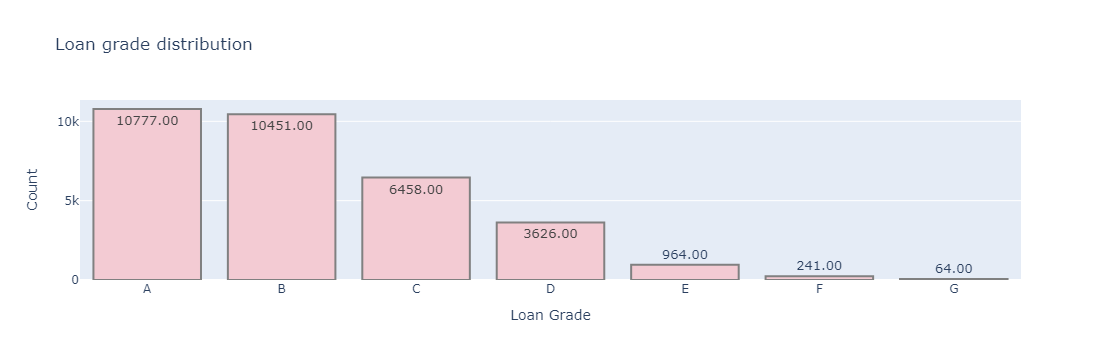

In [686]:
counts=data.loan_grade.value_counts()

fig = px.bar(x=counts.index, y=counts.values, color_discrete_sequence=px.colors.sequential.Magenta, 
             title='Loan grade distribution')

fig.update_layout(xaxis_title='Loan Grade', yaxis_title='Count')
fig.update_traces(texttemplate='%{y:.2f}', textposition='auto', textfont_size=13, marker=dict(line=dict(color='#102000', width=.2)))

fig.data[0].marker.line.width = 2
fig.data[0].marker.line.color='gray'
fig.show()

loan_grade: The grade assigned to the loan based on the creditworthiness of the borrower.
* A: The borrower has a high creditworthiness, indicating low risk.
* B: The borrower is relatively low-risk, but not as creditworthy as Grade A.
* C: The borrower's creditworthiness is moderate.
* D: The borrower is considered to have higher risk compared to previous grades.
* E: The borrower's creditworthiness is lower, indicating a higher risk.
* F: The borrower poses a significant credit risk.
* G: The borrower's creditworthiness is the lowest, signifying the highest risk.

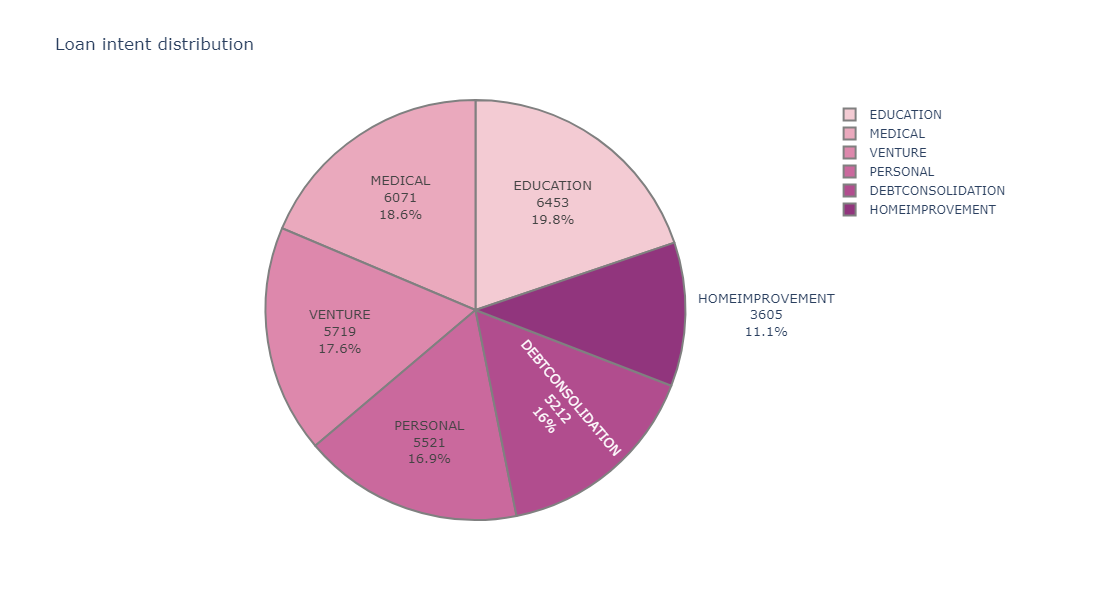

In [687]:
counts = data.loan_intent.value_counts()

fig = px.pie(values=counts.values, names=counts.index, color_discrete_sequence=px.colors.sequential.Magenta, 
             title='Loan intent distribution')

fig.update_traces(textinfo='label+percent+value', textfont_size=13, marker=dict(line=dict(color='#102000', width=.2)))

fig.data[0].marker.line.width = 2
fig.data[0].marker.line.color = 'gray'
fig.update_layout(width=800, height=600)
fig.show()

All intents are comparable with 'EDUCATION' and 'MEDICAL' slightly standing out.

#### <a name='1.3.2'></a>Multivariate Analysis

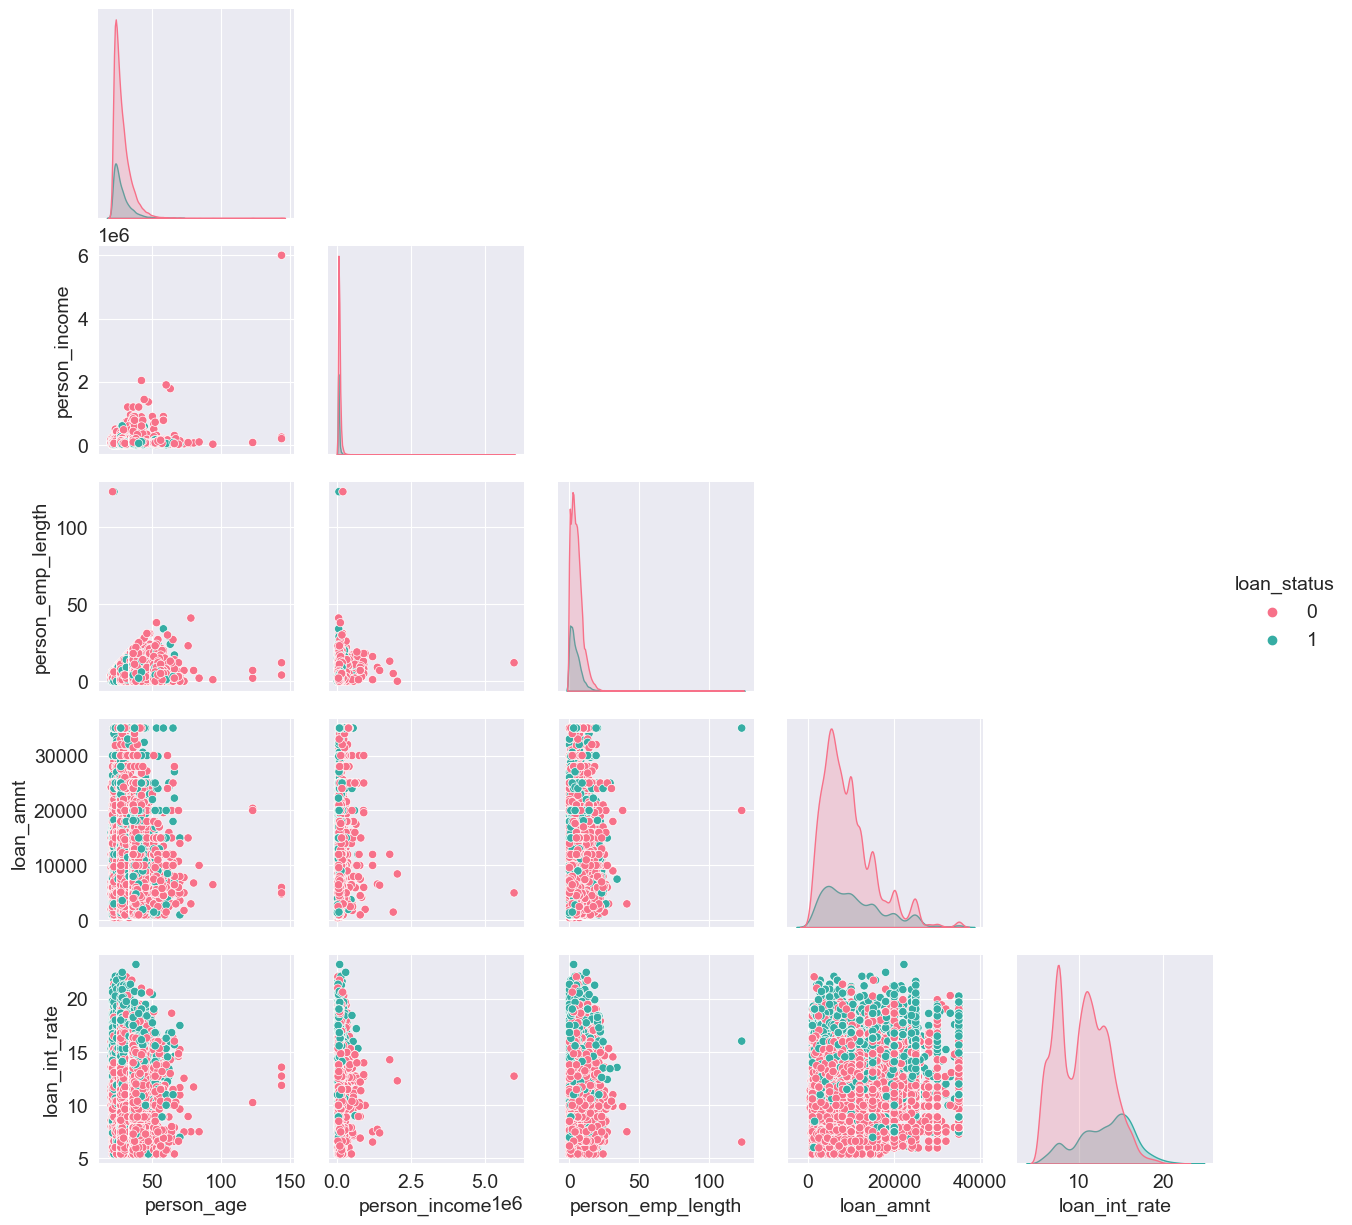

In [688]:
# pairplot
sns.pairplot(data=data[['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_status', 'loan_int_rate']], 
             hue='loan_status', corner=True, palette='husl')

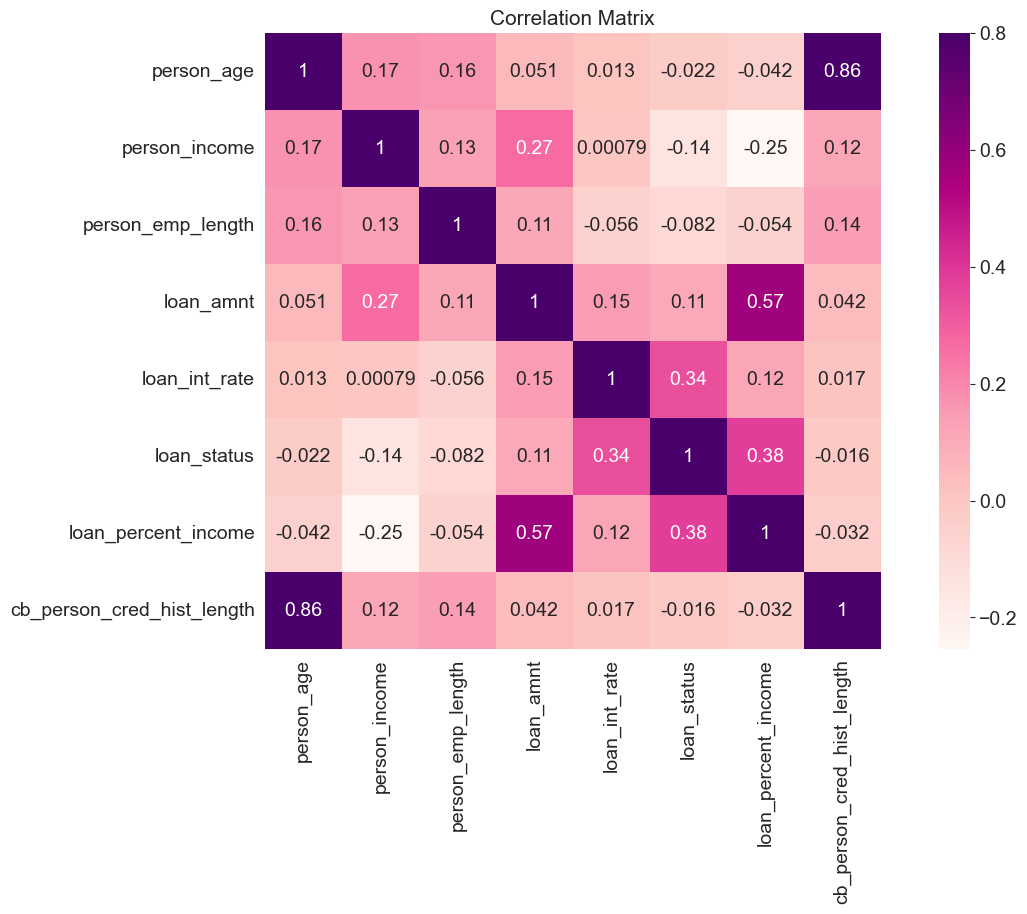

In [692]:
# heatmap
fig, ax = plt.subplots() 

fig.set_size_inches(15, 8)
sns.heatmap(data[num_col].corr(), vmax =.8, square = True, annot = True, cmap='RdPu' )
plt.title('Correlation Matrix', fontsize=15)
plt.show()

Correlations worth noticing:
* **person_age and cb_person_cred_hist_length** - Older people tend to have longer credit history.
* **loan_amnt and loan_percent_income** - This indicates that larger loans may require a higher proportion of the borrower's income to service, potentially indicating increased financial strain. This relationship highlights the importance of considering not only the absolute loan amount but also its relative impact on the borrower's income when assessing creditworthiness.

### <a name='1.4'></a>Data Quality Evaluation

Here we deal with NaN values, duplicates and outliers.

In [693]:
# remove NaN values
print(f"Shape of Data before removing NaNs -----> ({data.shape[0]}, {data.shape[1]}) \n")
data.dropna(axis=0, inplace=True)
print(f"Shape of Data after removing NaNs -----> ({data.shape[0]}, {data.shape[1]})")

Shape of Data before removing NaNs -----> (32581, 12) 

Shape of Data after removing NaNs -----> (28638, 12)


In [694]:
# as mentioned before we will not remove duplicates from this dataset
# in case we would want to remove duplicated we could do it as follows:
#print(f"Shape of Data before removing duplicates -----> ({data.shape[0]}, {data.shape[1]}) \n")
#data.drop_duplicates(inplace=True)
#print(f"Shape of Data after removing duplicates -----> ({data.shape[0]}, {data.shape[1]})")

In [695]:
# dealing with outliers
print(f"Shape of Data before dealing with outliers -----> ({data.shape[0]}, {data.shape[1]}) \n")
# drop people with employment length > 40
data = data.drop(data[data['person_emp_length'] > 40].index, axis=0)
# drop income above 1000000
data = data.drop(data[data['person_income'] > 1000000].index, axis=0)
# drop age above 70
data = data.drop(data[data['person_age'] > 70].index, axis=0)
print(f"Shape of Data after dealing with outliers -----> ({data.shape[0]}, {data.shape[1]}) \n")

Shape of Data before dealing with outliers -----> (28638, 12) 

Shape of Data after dealing with outliers -----> (28620, 12) 



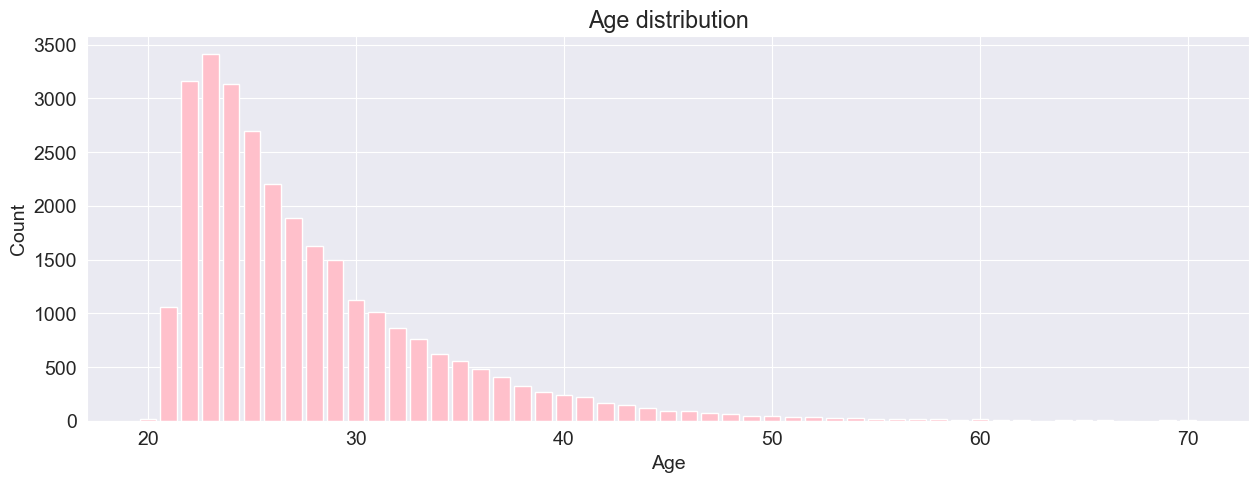

In [696]:
# draw chart again to see difference
counts = data['person_age'].value_counts().values
age = data['person_age'].value_counts().index

fig = plt.figure(figsize = (15, 5))
plt.bar(age, counts, color='pink')
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [697]:
data.reset_index(inplace = True)

### <a name='1.5'></a>Feature Engineering

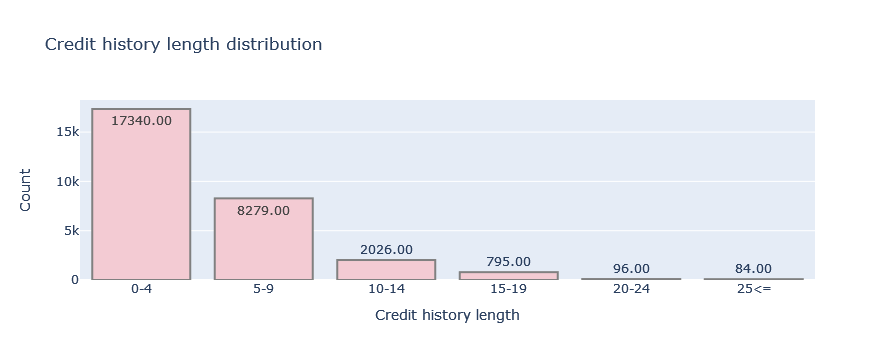

In [698]:
data['cred_hist_length_group'] = pd.cut(data['cb_person_cred_hist_length'],
                           bins=[0, 5, 10, 15, 20, 25, 30],
                           labels=['0-4', '5-9', '10-14', '15-19', '20-24', '25<='])

counts=data.cred_hist_length_group.value_counts()

fig = px.bar(x=counts.index, y=counts.values, color_discrete_sequence=px.colors.sequential.Magenta, 
             title='Credit history length distribution')

fig.update_layout(xaxis_title='Credit history length', yaxis_title='Count')
fig.update_traces(texttemplate='%{y:.2f}', textposition='auto', textfont_size=13, marker=dict(line=dict(color='#102000', width=.2)))

fig.data[0].marker.line.width = 2
fig.data[0].marker.line.color='gray'
fig.show()

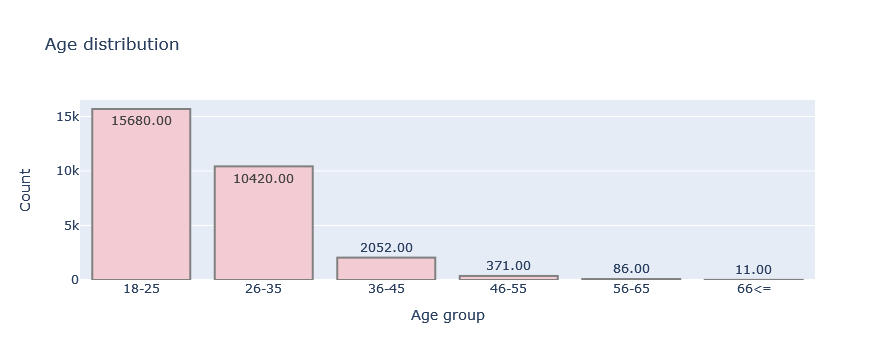

In [699]:
data['age_group'] = pd.cut(data['person_age'],
                           bins=[18, 26, 36, 46, 56, 66, float('inf')],
                           labels=['18-25', '26-35', '36-45', '46-55', '56-65', '66<='])

counts=data.age_group.value_counts()

fig = px.bar(x=counts.index, y=counts.values, color_discrete_sequence=px.colors.sequential.Magenta, 
             title='Age distribution')

fig.update_layout(xaxis_title='Age group', yaxis_title='Count')
fig.update_traces(texttemplate='%{y:.2f}', textposition='auto', textfont_size=13, marker=dict(line=dict(color='#102000', width=.2)))

fig.data[0].marker.line.width = 2
fig.data[0].marker.line.color='gray'
fig.show()

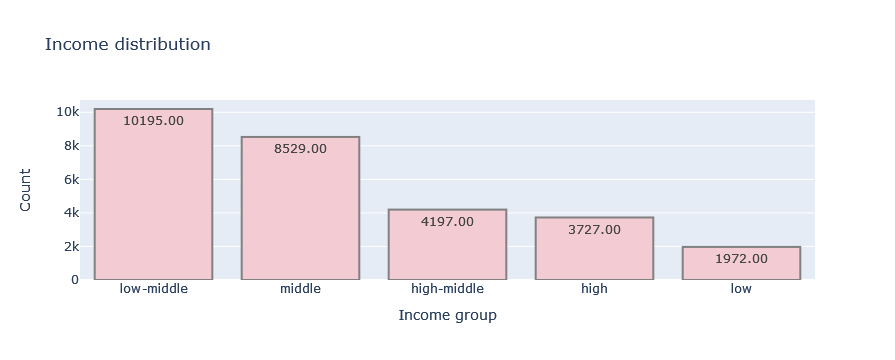

In [700]:
data['income_group'] = pd.cut(data['person_income'],
                           bins=[0, 25000, 50000, 75000, 100000, float('inf')],
                           labels=['low', 'low-middle', 'middle', 'high-middle', 'high'])

counts=data.income_group.value_counts()

fig = px.bar(x=counts.index, y=counts.values, color_discrete_sequence=px.colors.sequential.Magenta, 
             title='Income distribution')

fig.update_layout(xaxis_title='Income group', yaxis_title='Count')
fig.update_traces(texttemplate='%{y:.2f}', textposition='auto', textfont_size=13, marker=dict(line=dict(color='#102000', width=.2)))

fig.data[0].marker.line.width = 2
fig.data[0].marker.line.color='gray'
fig.show()

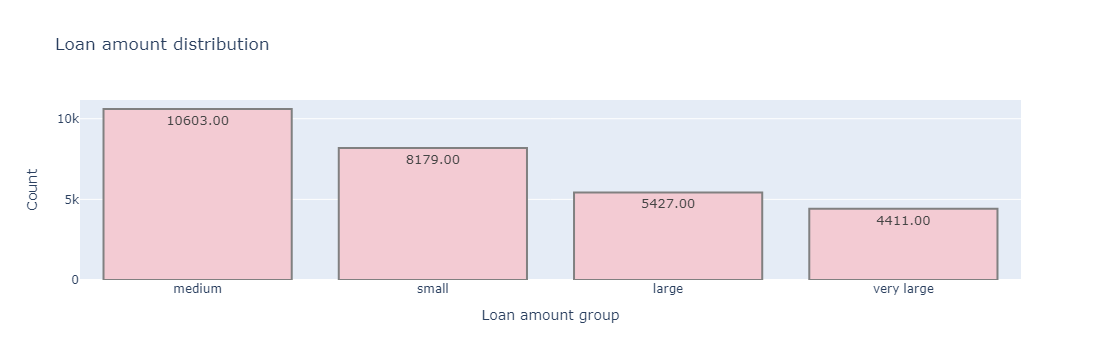

In [701]:
data['loan_amount_group'] = pd.cut(data['loan_amnt'],
                           bins=[0, 5000, 10000, 15000, float('inf')],
                            labels=['small', 'medium', 'large', 'very large'])

counts=data.loan_amount_group.value_counts()

fig = px.bar(x=counts.index, y=counts.values, color_discrete_sequence=px.colors.sequential.Magenta, 
             title='Loan amount distribution')

fig.update_layout(xaxis_title='Loan amount group', yaxis_title='Count')
fig.update_traces(texttemplate='%{y:.2f}', textposition='auto', textfont_size=13, marker=dict(line=dict(color='#102000', width=.2)))

fig.data[0].marker.line.width = 2
fig.data[0].marker.line.color='gray'
fig.show()

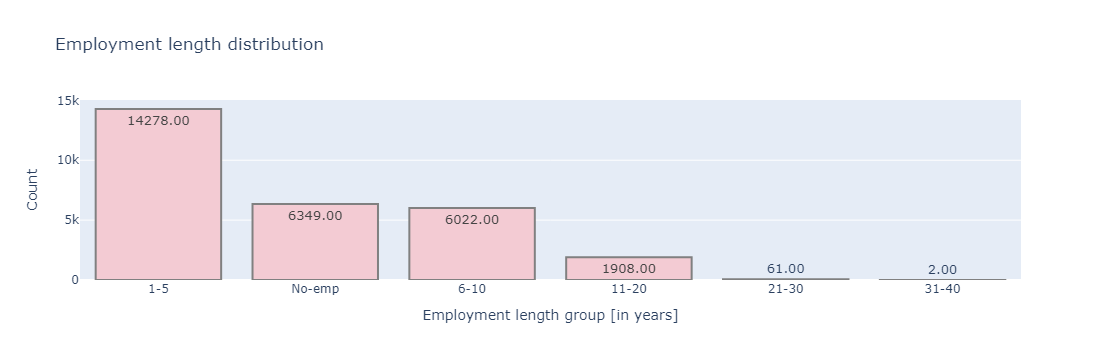

In [702]:
data['person_emp_length_group'] = pd.cut(data['person_emp_length'],
                           bins=[-1, 1, 6, 11, 21, 31, 40],
                            labels=['No-emp', '1-5', '6-10', '11-20', '21-30', '31-40'])

counts=data.person_emp_length_group.value_counts()

fig = px.bar(x=counts.index, y=counts.values, color_discrete_sequence=px.colors.sequential.Magenta, 
             title='Employment length distribution')

fig.update_layout(xaxis_title='Employment length group [in years]', yaxis_title='Count')
fig.update_traces(texttemplate='%{y:.2f}', textposition='auto', textfont_size=13, marker=dict(line=dict(color='#102000', width=.2)))

fig.data[0].marker.line.width = 2
fig.data[0].marker.line.color='gray'
fig.show()

In [703]:
# Create loan-to-income ratio
data['loan_to_income_ratio'] = data['loan_amnt'] / data['person_income']

# Create loan-to-employment length ratio
data['loan_to_emp_length_ratio'] =  data['person_emp_length']/ data['loan_amnt'] 

# Create interest rate-to-loan amount ratio
data['int_rate_to_loan_amt_ratio'] = data['loan_int_rate'] / data['loan_amnt']

data.head()

,index,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,...,cb_person_default_on_file,cb_person_cred_hist_length,cred_hist_length_group,age_group,income_group,loan_amount_group,person_emp_length_group,loan_to_income_ratio,loan_to_emp_length_ratio,int_rate_to_loan_amt_ratio
0,1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,...,N,2,0-4,18-25,low,small,1-5,0.104167,0.005000,0.011140
1,2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,...,N,3,0-4,18-25,low,medium,No-emp,0.572917,0.000182,0.002340
2,3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,...,N,2,0-4,18-25,middle,very large,1-5,0.534351,0.000114,0.000435
3,4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,...,Y,4,0-4,18-25,middle,very large,6-10,0.643382,0.000229,0.000408
4,5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,...,N,2,0-4,18-25,low,small,1-5,0.252525,0.000800,0.002856


## <a name='2'></a>EDA using ydata-profiling

Alternatively we could have performed EDA using ydata-profiling. Let's explore.

### <a name='2.1'></a>Load Data

In [704]:
# load 
ydata = pd.read_csv('credit_risk_dataset.csv') 

ydata.sample(5).reset_index(drop=True)  # overview

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,26,64000,RENT,2.0,MEDICAL,A,3000,NaN,0,0.05,N,4
1,36,50000,RENT,4.0,HOMEIMPROVEMENT,A,15000,8.90,0,0.30,N,14
2,33,98000,RENT,2.0,EDUCATION,A,20000,6.91,0,0.20,N,5
3,35,75000,OWN,9.0,VENTURE,A,7600,NaN,0,0.10,N,7
4,22,29950,RENT,0.0,HOMEIMPROVEMENT,D,10750,14.11,1,0.36,N,3


### <a name='2.2'></a>Profile Report

In [705]:
from ydata_profiling import ProfileReport

# generate the report
profile = ProfileReport(ydata, title='Credit Risk Profile')

# save to .html
profile.to_file('creditrisk_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Results are to be viewed in *creditrisk_report.html* file.

## <a name='3'></a>Data preprocessing

In [706]:
# first let's label categorical columns
# divide into numerical and categorical columns once again
num_col2 = []
cat_col2 = []
for i, j in data.dtypes.items():
    if j == 'object' or j == 'category':
        cat_col2.append(i)
    else:
        num_col2.append(i)     
    
print("The number of Categorical columns are:",len(cat_col2))
print("The number of Numerical columns are:",len(num_col2))

The number of Categorical columns are: 9
The number of Numerical columns are: 12


In [707]:
print("The NUMERICAL columns are:\n")
for i in num_col2:
    print("->",i,"-",data[i].nunique())
    
print("\n---------------------------\n")
print("The CATEGORICAL columns are:\n")
for i in cat_col2:
    print("->",i,"-",data[i].nunique())

The NUMERICAL columns are:

-> index - 28620
-> person_age - 50
-> person_income - 3828
-> person_emp_length - 34
-> loan_amnt - 728
-> loan_int_rate - 348
-> loan_status - 2
-> loan_percent_income - 77
-> cb_person_cred_hist_length - 29
-> loan_to_income_ratio - 8917
-> loan_to_emp_length_ratio - 1963
-> int_rate_to_loan_amt_ratio - 9346

---------------------------

The CATEGORICAL columns are:

-> person_home_ownership - 4
-> loan_intent - 6
-> loan_grade - 7
-> cb_person_default_on_file - 2
-> cred_hist_length_group - 6
-> age_group - 6
-> income_group - 5
-> loan_amount_group - 4
-> person_emp_length_group - 6


In [708]:
# One Hot Encoder for categorical columns
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
ohe.fit(data[cat_col2])

OneHotEncoder()

In [709]:
ohe.categories_

[array(['MORTGAGE', 'OTHER', 'OWN', 'RENT'], dtype=object),
 array(['DEBTCONSOLIDATION', 'EDUCATION', 'HOMEIMPROVEMENT', 'MEDICAL',
        'PERSONAL', 'VENTURE'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E', 'F', 'G'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['0-4', '10-14', '15-19', '20-24', '25<=', '5-9'], dtype=object),
 array(['18-25', '26-35', '36-45', '46-55', '56-65', '66<='], dtype=object),
 array(['high', 'high-middle', 'low', 'low-middle', 'middle'], dtype=object),
 array(['large', 'medium', 'small', 'very large'], dtype=object),
 array(['1-5', '11-20', '21-30', '31-40', '6-10', 'No-emp'], dtype=object)]

In [710]:
merge_ohe_col = np.concatenate((ohe.categories_[0], 
                ohe.categories_[1],
                ohe.categories_[2],
                ohe.categories_[3],
                ohe.categories_[4],
                ohe.categories_[5],
                ohe.categories_[6],
                ohe.categories_[7],
                ohe.categories_[8],))

merge_ohe_col

array(['MORTGAGE', 'OTHER', 'OWN', 'RENT', 'DEBTCONSOLIDATION',
       'EDUCATION', 'HOMEIMPROVEMENT', 'MEDICAL', 'PERSONAL', 'VENTURE',
       'A', 'B', 'C', 'D', 'E', 'F', 'G', 'N', 'Y', '0-4', '10-14',
       '15-19', '20-24', '25<=', '5-9', '18-25', '26-35', '36-45',
       '46-55', '56-65', '66<=', 'high', 'high-middle', 'low',
       'low-middle', 'middle', 'large', 'medium', 'small', 'very large',
       '1-5', '11-20', '21-30', '31-40', '6-10', 'No-emp'], dtype=object)

In [711]:
ohe_data = pd.DataFrame(ohe.transform(data[cat_col2]).toarray(), columns=merge_ohe_col)

new_data = pd.concat([ohe_data, data], axis=1)
new_data = new_data.drop(cat_col2, axis=1)

new_data.head()

,MORTGAGE,OTHER,OWN,RENT,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE,...,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,loan_to_income_ratio,loan_to_emp_length_ratio,int_rate_to_loan_amt_ratio
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,9600,5.0,1000,11.14,0,0.10,2,0.104167,0.005000,0.011140
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,9600,1.0,5500,12.87,1,0.57,3,0.572917,0.000182,0.002340
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,65500,4.0,35000,15.23,1,0.53,2,0.534351,0.000114,0.000435
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,54400,8.0,35000,14.27,1,0.55,4,0.643382,0.000229,0.000408
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,9900,2.0,2500,7.14,1,0.25,2,0.252525,0.000800,0.002856


In [712]:
# scale numerical columns
from sklearn.preprocessing import StandardScaler

normal_col = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 
              'loan_percent_income', 'cb_person_cred_hist_length', 
              'loan_to_income_ratio', 'loan_to_emp_length_ratio', 'int_rate_to_loan_amt_ratio']

scaler_normal = StandardScaler()
new_data.loc[:, normal_col] = scaler_normal.fit_transform(new_data.loc[:, normal_col])

new_data.head()

,MORTGAGE,OTHER,OWN,RENT,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE,...,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,loan_to_income_ratio,loan_to_emp_length_ratio,int_rate_to_loan_amt_ratio
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-1.203857,0.055135,-1.367785,0.030830,0,-0.653851,-0.941082,-0.616455,3.943446,4.965624
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-1.203857,-0.937915,-0.656713,0.566531,1,3.765565,-0.692609,3.779818,-0.544354,0.253926
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.013340,-0.193128,4.004761,1.297313,1,3.389444,-0.941082,3.418123,-0.607256,-0.765973
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.249740,0.799922,4.004761,1.000046,1,3.577504,-0.444135,4.440696,-0.500807,-0.780659
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-1.197468,-0.689652,-1.130761,-1.207784,1,0.756601,-0.941082,0.774958,0.031439,0.530203


In [713]:
# adressing imbalanced issues 
# our dataset is imbalanced, as we found out earlier 
# let's look at the 0-1 proportion again
new_data.loan_status.value_counts()

loan_status
0    22418
1     6202
Name: count, dtype: int64

We could leave our dataset unchanged remembering to choose proper evaluation metric while considering different ML models. In general, for an imbalanced class dataset F1 score is appropriate, as it is the harmonic mean of precistion and recall and increases only if both the number and quality of prediction improves. 

However, for the case of this project we will try *Oversampling and Undersampling* techniques using:
* the sklear library's resample()
* Synthetic Minority Oversampling Technique (SMOTE)

In [714]:
# the sklear library's resample()
from sklearn.utils import resample

# create two different datasets for majority and minority class
data_majority = new_data[(new_data['loan_status']==0)] 
data_minority = new_data[(new_data['loan_status']==1)] 

# upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 22418, # to match majority class
                                 random_state=42)  # reproducible results

# combine majority class with upsampled minority class
data_upsampled = pd.concat([data_minority_upsampled, data_majority])

In [715]:
# result
data_upsampled.loan_status.value_counts()

loan_status
1    22418
0    22418
Name: count, dtype: int64

Text(0.5, 1.0, 'Loan Status Upsampled')

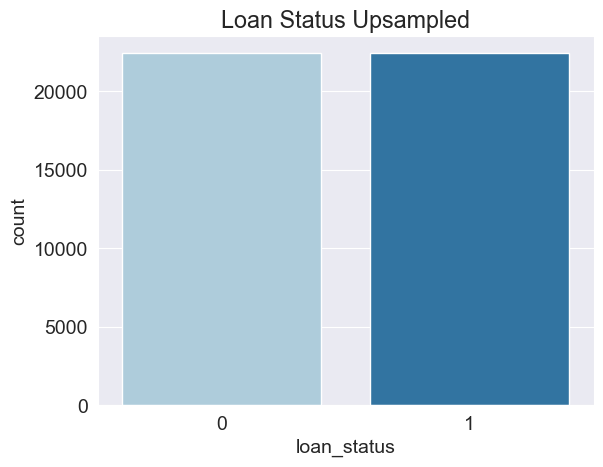

In [716]:
# visualization
sns.countplot(x=data_upsampled['loan_status'], palette='Paired')
plt.title('Loan Status Upsampled')

In [717]:
# SMOTE
from imblearn.over_sampling import SMOTE

# resample the minority class
sm = SMOTE(sampling_strategy='minority', random_state=42)

# fit the model to generate data
oversampled_X, oversampled_Y = sm.fit_resample(new_data.drop('loan_status', axis=1), new_data['loan_status'])

data_SMOTE = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

In [718]:
# result
data_SMOTE.loan_status.value_counts()

loan_status
0    22418
1    22418
Name: count, dtype: int64

Text(0.5, 1.0, 'Loan Status after SMOTE')

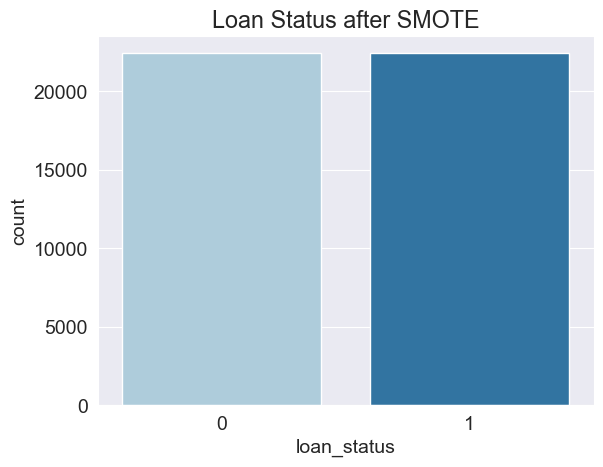

In [719]:
# visualization
sns.countplot(x=data_SMOTE['loan_status'], palette='Paired')
plt.title('Loan Status after SMOTE')

In sklearn .resample() method we simply added duplicated rows to our dataset. It worked with balance but did not provide any new information to the model. In SMOTE new instances are synthesized from the existing data and because of this adventage we will move on with its results to the rest of the preprocessing part.

In [720]:
# split dataset into training and testing part
X = data_SMOTE.drop(['loan_status'], axis=1)
Y = data_SMOTE['loan_status']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=12)

print(x_train.shape, x_test.shape)

(35868, 57) (8968, 57)


In [721]:
x_train.reset_index(inplace = True)
x_test.reset_index(inplace = True)

## <a name='4'></a>Machine Learning

In [722]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.metrics import mean_squared_error as MSE
from hyperopt import hp, fmin, tpe
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold, cross_val_score
from lightgbm import LGBMClassifier

In [723]:
# ML models to chose from:
svc = SVC()
knc = KNeighborsClassifier() #algorithm='ball_tree', leaf_size=10, n_neighbors=18, p=1, weights='distance'
mnb = MultinomialNB()
dtc = DecisionTreeClassifier()
lrc = LogisticRegression()
rfc = RandomForestClassifier()
abc = AdaBoostClassifier()
bc = BaggingClassifier()
etc = ExtraTreesClassifier()
gbdt = GradientBoostingClassifier()
xgb = XGBClassifier()
cat = CatBoostClassifier(verbose=0) 
lgb = lgb.LGBMClassifier()

In [724]:
# chosen:
clfs = {
    'LogisticRegression': lrc,
    'KNeighborsClassifier' : knc, 
    'XGBClassifier': xgb,
    'CatBoostClassifier': cat,
    'DecisionTreeClassifier': dtc,
    'LGBMClassifier': lgb
}

In [725]:
# clfs = {
#     'SVC' : svc,
#     'KNeighborsClassifie' : knc, 
#     'MultinomialNB': mnb, 
#     'DecisionTreeClassifier': dtc, 
#     'LogisticRegression': lrc, 
#     'RandomForestClassifier': rfc, 
#     'AdaBoostClassifier': abc, 
#     'BaggingClassifier': bc, 
#     'ExtraTreesClassifier': etc,
#     'GradientBoostingClassifier': gbdt,
#     'XGBClassifier': xgb
#     'CatBoostClassifier' : cat,
#     'LGBMClassifier': lgb 
# }

In [726]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix

# function: train classifier and evaluate
def train_classifier(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Calculate confusion matrix to get TN and FP for specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    return accuracy, precision, recall, specificity

In [727]:
# chack again for NaN values just in case
x_train = x_train.drop(columns=[col for col in x_train.columns if pd.isna(col)], axis=1)
x_test = x_test.drop(columns=[col for col in x_test.columns if pd.isna(col)], axis=1)

# ensure continouity
x_train = np.ascontiguousarray(x_train)
x_test = np.ascontiguousarray(x_test)

In [728]:
# compare chosen ML models
results = []

for name, clf in clfs.items():
    current_accuracy, current_precision, current_recall, current_specificity = train_classifier(clf, x_train, y_train, 
                                                                                                x_test, y_test)

    results.append({
        'Model Name': name,
        'Accuracy': current_accuracy,
        'Precision': current_precision,
        'Recall': current_recall,
        'Specificity': current_specificity
    })

df = pd.DataFrame(results)

[LightGBM] [Info] Number of positive: 17871, number of negative: 17997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12652
[LightGBM] [Info] Number of data points in the train set: 35868, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498244 -> initscore=-0.007026
[LightGBM] [Info] Start training from score -0.007026


In [729]:
# view the results
df

,Model Name,Accuracy,Precision,Recall,Specificity
0,LogisticRegression,0.899532,0.947033,0.849351,0.951142
1,KNeighborsClassifier,0.859723,0.928590,0.783594,0.938023
2,XGBClassifier,0.965098,0.993473,0.937321,0.993667
3,CatBoostClassifier,0.966659,0.996262,0.937761,0.996381
4,DecisionTreeClassifier,0.930754,0.928603,0.935342,0.926035
5,LGBMClassifier,0.962087,0.996460,0.928524,0.996607


Metrics used:
* **Accuracy** measures the proportion of correct predictions made by a model out of all predictions made. Good for balanced models. 
* **Precision** measures the proportion of true positive predictions out of all positive predictions made by the model.
* **Recall** (sensitivity) measures the proportion of true positive predictions out of all actual positive instances in the data. 
* **Specificity** measures the proportion of true negative predictions out of all actual negative instances in the data. 

## <a name='5'></a>Conclusions

When chosing the right ML model it's worth considering the business context. 

**Scenario 1.**
The cost of false positives is high. Mostly we don't want to deny credit to a customer who would have paid back the loan so that **recall** is most important metric.

**Scenario 2.**
The cost of false negatives is high. We are afraid to grant credit to a consumer who will default so **precision** is better.

We can also use **Accuracy** as we have taken care of imbalanced classes before training our model.

In [730]:
print(f'The best ML model for Scenario 1. is {df[df["Recall"] == df["Recall"].max()]["Model Name"].values[0]} with Recall Score = {df["Recall"].max()}.')
print(f'The best ML model for Scenario 2. is {df[df["Precision"] == df["Precision"].max()]["Model Name"].values[0]} with Precision Score = {df["Precision"].max()}.')

The best ML model for Scenario 1. is CatBoostClassifier with Recall Score = 0.9377611612051903.
The best ML model for Scenario 2. is LGBMClassifier with Precision Score = 0.99645975926363.


In [731]:
print(f'In terms of accuracy the best ML model is {df[df["Accuracy"] == df["Accuracy"].max()]["Model Name"].values[0]} with Accuracy Score = {df["Accuracy"].max()}.')

In terms of accuracy the best ML model is CatBoostClassifier with Accuracy Score = 0.9666592328278323.
